#AIM:

Generate random sequences, fold them with RNAfold, learn the mapping between seq features and struct features

Measure how good the mapping is by trying to learn the two version apart

In [220]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from eden.util import configure_logging
import logging
logger = logging.getLogger()
configure_logging(logger,verbosity=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [221]:
from eden.converter.rna.rnafold import rnafold_to_eden
from eden.converter.fasta import sequence_to_eden
from eden.util import mp_pre_process
from eden.util import vectorize
from eden import graph

In [222]:
from eden.util.display import draw_graph
import itertools
def plot(graphs, num=3, opts=None):    
    graphs = itertools.islice(graphs,num)
    for i,graph in enumerate(graphs): 
        draw_graph(graph, **opts)

In [223]:
import random
def generate_rna_seq(length=30, gc_content=0.5):
    n_g=int(gc_content * length / 2)
    n_c=int(gc_content * length / 2)
    n_a=int((1 - gc_content) * length / 2)
    n_u=int((1 - gc_content) * length / 2)
    seq = list('G'*n_g + 'C'*n_c + 'A'*n_a + 'U'*n_u)
    random.shuffle(seq)
    seq = ''.join(seq)
    return seq

def generate_rna_seqs(num=100, length=30, gc_content=0.5):
    seqs = []
    for i in range(num):
        seqs.append(('ID_%d'%i, generate_rna_seq(length=length, gc_content=gc_content)))
    return seqs

In [224]:
def plot_examples(seqs, pre_processor=None):
    graphs = mp_pre_process(seqs,
                            pre_processor=pre_processor,
                            pre_processor_args={},
                            n_jobs=-1)    
    opts={'size':8,
          'node_border':False,
          'node_size':400,
          'font_size':9,
          'vertex_alpha':0.6,
          'title_key':'id',
          'vertex_color':'_labels_',
          'colormap':'Set1',
          'prog':'neato'}
    plot(graphs, num=None, opts=opts)

In [225]:
#RNAplfold
def pre_processor(seqs):
    from eden.converter.rna.rnaplfold import rnaplfold_to_eden
    graphs = rnaplfold_to_eden(seqs,
                               window_size = 30,
                               max_bp_span = 20,
                               avg_bp_prob_cutoff = 0.5,
                               max_num_edges = 1)
    from eden.modifier.graph import structure 
    graphs = structure.basepair_to_nesting(graphs)
    #graphs = structure.del_basepair(graphs)
    return graphs

In [226]:
#RNAfold
def pre_processor(seqs):
    from eden.converter.rna.rnafold import rnafold_to_eden
    graphs = rnafold_to_eden(seqs)
    from eden.modifier.graph import structure 
    graphs = structure.basepair_to_nesting(graphs)
    return graphs

In [227]:
from eden.util import mp_pre_process
from eden.util import vectorize
def transformer(seqs, vectorizer=None, pre_processor=None):
    graphs = mp_pre_process(seqs,
                            pre_processor=pre_processor,
                            pre_processor_args={},
                            n_jobs=-1)
    data_matrix = vectorize(graphs, vectorizer=vectorizer, n_jobs=-1)
    return data_matrix

#Experimental setup

In [228]:
num=2500
length=17
gc_content=0.6
nbits=10

In [229]:
seqs = generate_rna_seqs(num=num, length=length, gc_content=gc_content)

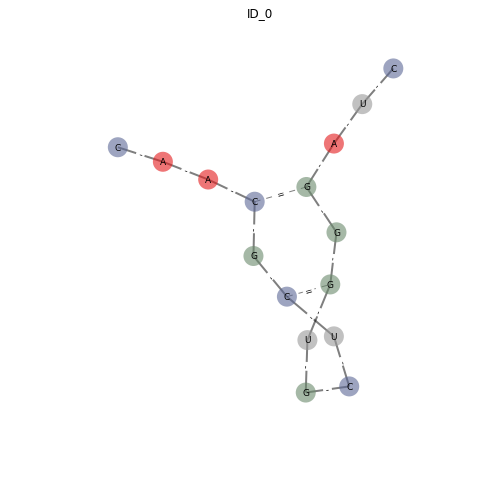

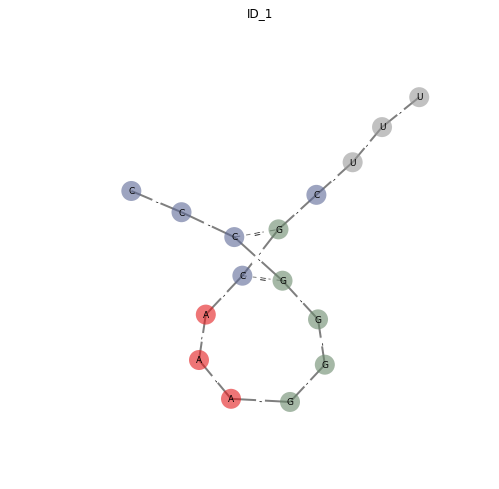

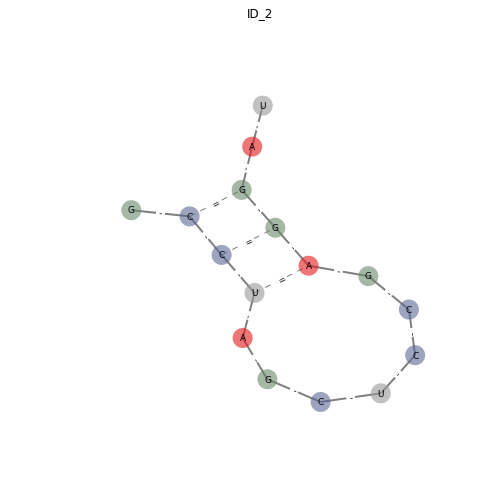

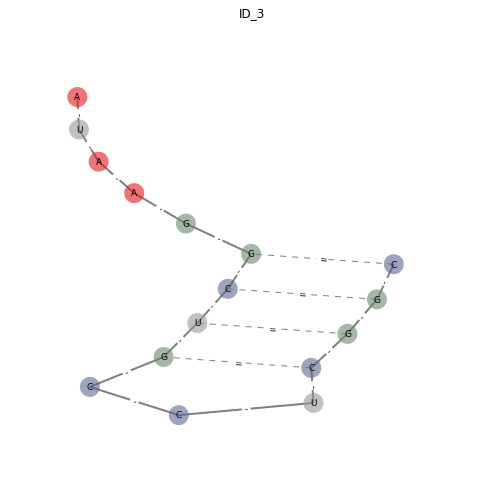

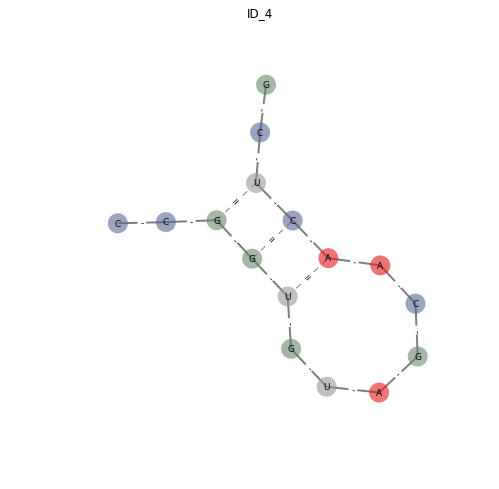

In [230]:
plot_examples(seqs[:5],pre_processor)

In [231]:
%%time
from eden.converter.fasta import sequence_to_eden
from eden import graph
X_seq = transformer(seqs,
                    vectorizer=graph.Vectorizer(r=3,d=17,min_r=2,
                                                normalization=False,
                                                inner_normalization=False,
                                                nbits=nbits),
                    pre_processor=sequence_to_eden)
from eden.util import describe
print describe(X_seq)
print X_seq

Instances: 2500 ; Features: 1025 with an avg of 233 features per instance
  (0, 2)	2.0
  (0, 3)	2.0
  (0, 6)	2.0
  (0, 20)	2.0
  (0, 33)	2.0
  (0, 39)	2.0
  (0, 47)	2.0
  (0, 48)	1.0
  (0, 52)	2.0
  (0, 56)	1.0
  (0, 58)	2.0
  (0, 61)	2.0
  (0, 65)	2.0
  (0, 72)	2.0
  (0, 74)	2.0
  (0, 76)	2.0
  (0, 80)	2.0
  (0, 85)	2.0
  (0, 88)	2.0
  (0, 91)	2.0
  (0, 101)	2.0
  (0, 103)	2.0
  (0, 105)	2.0
  (0, 107)	2.0
  (0, 109)	2.0
  :	:
  (2499, 904)	2.0
  (2499, 905)	2.0
  (2499, 912)	2.0
  (2499, 922)	2.0
  (2499, 923)	2.0
  (2499, 924)	2.0
  (2499, 929)	2.0
  (2499, 938)	2.0
  (2499, 944)	2.0
  (2499, 950)	2.0
  (2499, 954)	1.0
  (2499, 955)	2.0
  (2499, 958)	2.0
  (2499, 971)	2.0
  (2499, 976)	2.0
  (2499, 982)	2.0
  (2499, 992)	2.0
  (2499, 993)	2.0
  (2499, 996)	1.0
  (2499, 998)	2.0
  (2499, 1002)	1.0
  (2499, 1012)	2.0
  (2499, 1013)	2.0
  (2499, 1017)	2.0
  (2499, 1018)	2.0
CPU times: user 3.79 s, sys: 643 ms, total: 4.43 s
Wall time: 7.51 s


In [232]:
%%time
from eden.converter.fasta import sequence_to_eden
from eden import graph
X_struct = transformer(seqs,
                       vectorizer=graph.Vectorizer(r=3,d=0,min_r=2,
                                                   normalization=False,
                                                   inner_normalization=False,
                                                   nbits=nbits),
                       pre_processor=pre_processor)
from eden.util import describe
print describe(X_struct)
print X_struct

Instances: 2500 ; Features: 1025 with an avg of 32 features per instance
  (0, 48)	1.0
  (0, 56)	1.0
  (0, 206)	1.0
  (0, 216)	1.0
  (0, 218)	1.0
  (0, 238)	1.0
  (0, 244)	1.0
  (0, 285)	1.0
  (0, 308)	1.0
  (0, 432)	1.0
  (0, 464)	2.0
  (0, 472)	1.0
  (0, 480)	2.0
  (0, 484)	2.0
  (0, 490)	1.0
  (0, 500)	1.0
  (0, 568)	1.0
  (0, 579)	1.0
  (0, 646)	2.0
  (0, 711)	1.0
  (0, 723)	1.0
  (0, 726)	1.0
  (0, 728)	1.0
  (0, 750)	2.0
  (0, 774)	1.0
  :	:
  (2499, 216)	1.0
  (2499, 308)	1.0
  (2499, 342)	1.0
  (2499, 346)	1.0
  (2499, 352)	1.0
  (2499, 432)	1.0
  (2499, 462)	1.0
  (2499, 506)	1.0
  (2499, 538)	2.0
  (2499, 560)	1.0
  (2499, 568)	1.0
  (2499, 658)	1.0
  (2499, 726)	1.0
  (2499, 750)	1.0
  (2499, 760)	1.0
  (2499, 810)	2.0
  (2499, 814)	1.0
  (2499, 864)	1.0
  (2499, 944)	2.0
  (2499, 954)	1.0
  (2499, 982)	2.0
  (2499, 992)	1.0
  (2499, 996)	1.0
  (2499, 1002)	1.0
  (2499, 1012)	2.0
CPU times: user 4.03 s, sys: 757 ms, total: 4.79 s
Wall time: 13.5 s


In [233]:
from sklearn.preprocessing import StandardScaler
seq_scale = StandardScaler(with_mean=True)
X_seq_std = seq_scale.fit_transform(X_seq.todense())
print X_seq_std

[[ 0.         -0.50972448  1.94677478 ...,  1.53932701 -0.53424818
  -0.51020537]
 [ 0.         -0.50972448 -0.49892218 ..., -0.63732317  1.83807944
   1.89642373]
 [ 0.         -0.50972448 -0.49892218 ..., -0.63732317  1.83807944
  -0.51020537]
 ..., 
 [ 0.         -0.50972448  1.94677478 ..., -0.63732317 -0.53424818
  -0.51020537]
 [ 0.         -0.50972448 -0.49892218 ..., -0.63732317 -0.53424818
  -0.51020537]
 [ 0.          1.88110328  1.94677478 ..., -0.63732317 -0.53424818
  -0.51020537]]


In [234]:
from sklearn.preprocessing import StandardScaler
struct_scale = StandardScaler(with_mean=True)
X_struct_std = seq_scale.fit_transform(X_struct.todense())
print X_struct_std

[[ 0.         -0.10833346 -0.08274392 ..., -0.08025724 -0.08025724
  -0.05665927]
 [ 0.         -0.10833346 -0.08274392 ..., -0.08025724 -0.08025724
  -0.05665927]
 [ 0.         -0.10833346 -0.08274392 ..., -0.08025724 -0.08025724
  -0.05665927]
 ..., 
 [ 0.         -0.10833346 -0.08274392 ..., -0.08025724 -0.08025724
  -0.05665927]
 [ 0.         -0.10833346 -0.08274392 ..., -0.08025724 -0.08025724
  -0.05665927]
 [ 0.         -0.10833346 -0.08274392 ..., -0.08025724 -0.08025724
  -0.05665927]]


In [235]:
X_seq_std = X_seq.todense()
X_struct_std = X_struct.todense()

In [236]:
n_features_in = X_seq.shape[1]
n_features_out = X_struct.shape[1]
n_features_hidden = max(n_features_in, n_features_out) * 3
print 'n_neurons: #in [%d] -- #hidden [%d] -- #out [%d]' % (n_features_in, n_features_hidden, n_features_out)

n_neurons: #in [1025] -- #hidden [3075] -- #out [1025]


In [237]:
from sknn.mlp import Regressor, Layer

net = Regressor(layers=[
        Layer("Rectifier", units=n_features_hidden),
        Layer("Rectifier", units=n_features_hidden),
        Layer("Rectifier", units=n_features_hidden),
        Layer("Softmax", units=n_features_out)],
                learning_rate=0.0001,
                n_iter=100,
                batch_size=10,
                regularize='L1',
                valid_size=0.1)

In [238]:
%%time
net.fit(X_seq_std, X_struct_std)

CPU times: user 2h 29min 19s, sys: 11min 27s, total: 2h 40min 47s
Wall time: 1h 21min 54s


Regressor(batch_size=10, debug=False, dropout_rate=None, f_stable=0.001,
     hidden0=<sknn.nn.Layer `Rectifier`: name=u'hidden0', units=3075>,
     hidden1=<sknn.nn.Layer `Rectifier`: name=u'hidden1', units=3075>,
     hidden2=<sknn.nn.Layer `Rectifier`: name=u'hidden2', units=3075>,
     layers=[<sknn.nn.Layer `Rectifier`: name=u'hidden0', units=3075>, <sknn.nn.Layer `Rectifier`: name=u'hidden1', units=3075>, <sknn.nn.Layer `Rectifier`: name=u'hidden2', units=3075>, <sknn.nn.Layer `Softmax`: name=u'output', units=1025>],
     learning_momentum=0.9, learning_rate=0.0001, learning_rule=u'sgd',
     loss_type=u'mse', mutator=None, n_iter=100, n_stable=50,
     output=<sknn.nn.Layer `Softmax`: name=u'output', units=1025>,
     random_state=None, regularize='L1',
     valid_set=(matrix([[ 0.,  0., ...,  2.,  2.],
        [ 0.,  0., ...,  0.,  0.],
        ...,
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.]]), matrix([[ 0.,  0., ...,  1.,  0.],
        [ 0.,  0., ...,

In [239]:
%%time
# Transform seq features to struct features
X_struct_std_pred = net.predict(X_seq_std)

CPU times: user 11.7 s, sys: 95.1 ms, total: 11.8 s
Wall time: 2 s


In [240]:
import pylab as plt
import numpy as np

original_data = np.array(np.ravel(X_struct_std))
predicted_data = np.array(np.ravel(X_struct_std_pred))

combined_data = np.vstack([original_data,predicted_data])
gamma = np.corrcoef(combined_data)
print 'corr_coeff: %.3f' % gamma[0,1]
print 'n datapoints: %d' % predicted_data.shape[0]

noise = 0.065 * np.random.randn(*original_data.shape)
noisy_original_data = noise + original_data

corr_coeff: 0.828
n datapoints: 2562500


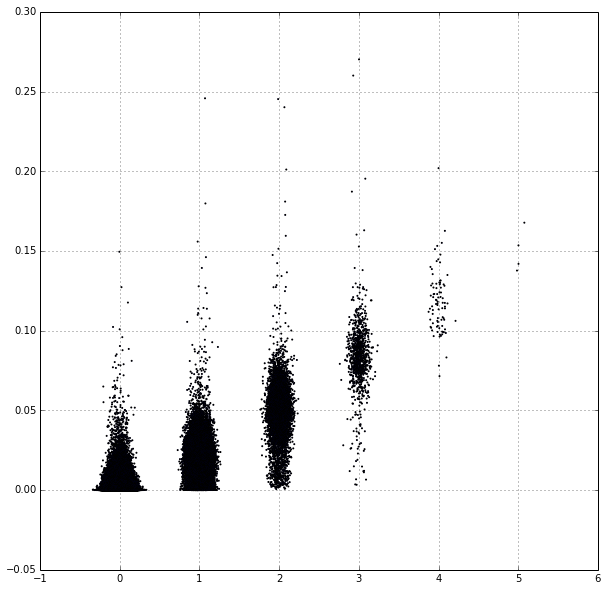

CPU times: user 1min 44s, sys: 560 ms, total: 1min 45s
Wall time: 1min 45s


In [241]:
%%time
plt.figure(figsize=(10,10)) 
plt.scatter(noisy_original_data,predicted_data, s=1)
plt.grid()
plt.show()

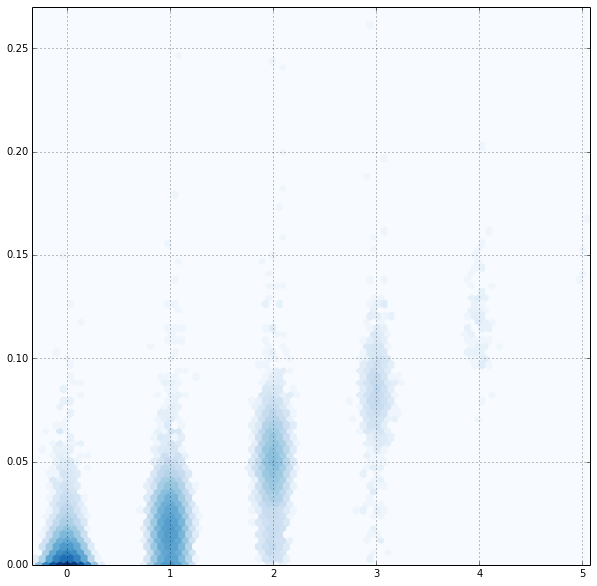

CPU times: user 15.4 s, sys: 415 ms, total: 15.8 s
Wall time: 15.6 s


In [242]:
%%time
plt.figure(figsize=(10,10)) 
plt.hexbin(noisy_original_data,predicted_data, 
           bins='log', gridsize=80, cmap='Blues')
plt.grid()
plt.show()